In this project, we'll build a simple convolutional neural network for CIFAR-10 image classification. Code contained in this project was based on Tensorflow 1.2.1 and python 3.5. 

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import tensorflow as tf
import helper
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()

# Preprocess Data

## Normalize

In [2]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    """
    batch_mean = np.mean(x)
    batch_std = np.std(x)
    x = x.astype(np.float32)
    for ii in range(x.shape[0]):
        x[ii,:,:,:] = (x[ii,:,:,:] - batch_mean) / batch_std
    return x

## One hot encode

In [3]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    smooth_factor = 0.1
    output = np.zeros([len(x), 10]) # +( smooth_factor / 9 )
    for idx, item in enumerate(x):
        output[idx, item] = 1. #- smooth_factor
    return output

This above function is equivalent to tf.one_hot(x, 10), but tensorflow module can not be pickled so we're sticking with the above implementation.

## Preprocess Data
We will randomly shuffle the data, normalize them and save them in binary format.

In [4]:
import tensorflow as tf
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, one_hot_encode)

# Checkpoint
The above work is all saved so when we're revisiting this notebook we don't have to do those work again. We can start from here.

In [5]:
import pickle
import helper

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))
valid_features = np.transpose(valid_features,(0, 3, 1, 2))
valid_features = normalize(valid_features)

# Building the network

## Defining input

In [6]:
def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], image_shape[2]], "x")


def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float32, [None, n_classes], "y")


def neural_net_keep_prob_input(n):
    return tf.placeholder(tf.float32, None, "keep_prob_"+str(n))


def neural_net_training_flag():
    return tf.placeholder(tf.bool, None, "train_flag")

## Convolution and maxpool layer

In [7]:
def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides, is_train):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    w = tf.get_variable("w", shape=[conv_ksize[0], conv_ksize[1], x_tensor.get_shape().as_list()[1], conv_num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    #b = tf.Variable(tf.truncated_normal([conv_num_outputs],
    #                                  mean=0.0, stddev=0.1, dtype=tf.float32))
    
    wc = tf.nn.conv2d(x_tensor, w, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME', data_format='NCHW')
    # z = tf.nn.bias_add(wc, b)
    z = tf.layers.batch_normalization(wc, training=is_train)
    
    return tf.nn.relu(z)



## Flatten layer
Implement the flatten function to change the dimension of x_tensor from a 4-D tensor to a 2-D tensor. The output should be the shape (Batch Size, Flattened Image Size). Shortcut option: you can use classes from the TensorFlow Layers or TensorFlow Layers (contrib) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [8]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # reference : https://github.com/tensorflow/tensorflow/issues/7253
    return tf.reshape(x_tensor, [tf.shape(x_tensor)[0], np.prod(x_tensor.get_shape().as_list()[1:])])
    
    # This also works
    #return tf.reshape(x_tensor, [-1, np.prod(x_tensor.shape[1:]).value])

## Fully connected layer

In [9]:
def fully_conn(x_tensor, num_outputs, is_train):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    fc = tf.reshape(x_tensor, [-1, np.prod(x_tensor.get_shape().as_list()[1:])])
    
    w = tf.get_variable("w", shape=[np.prod(x_tensor.get_shape().as_list()[1:]), num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    # b = tf.Variable(tf.truncated_normal([num_outputs],mean=0.0, stddev=0.1, dtype=tf.float32))
    z = tf.matmul(fc, w)
    z = tf.layers.batch_normalization(z, training=is_train)
    
    return tf.nn.relu(z)

## Output layer

In [10]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    w = tf.get_variable("w", shape=[np.prod(x_tensor.get_shape().as_list()[1:]), num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    b = tf.Variable(tf.truncated_normal([num_outputs],mean=0.0, stddev=0.1, dtype=tf.float32))
    return tf.add(tf.matmul(x_tensor, w), b)


## Create the convolutional neural network model

In [11]:
def conv_net(x, keep_prob_1, keep_prob_2, keep_prob_3, keep_prob_4,  train_flag):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    # Convolution and maxpooling layers
    with tf.variable_scope("conv1"):
        conv = conv2d(x, 64, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_1)
    with tf.variable_scope("conv2"):
        conv = conv2d(conv, 64, (3, 3), (1, 1), train_flag)
    conv = tf.nn.max_pool(conv, ksize=[1, 1, 2, 2], strides=[1, 1, 2, 2], padding='SAME', data_format='NCHW')
    conv = tf.nn.dropout(conv, keep_prob_1)
    
    with tf.variable_scope("conv3"):
        conv = conv2d(conv, 128, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_2)
    with tf.variable_scope("conv4"):
        conv = conv2d(conv, 128, (3, 3), (1, 1), train_flag)
    conv = tf.nn.max_pool(conv, ksize=[1, 1, 2, 2], strides=[1, 1, 2, 2], padding='SAME', data_format='NCHW')
    conv = tf.nn.dropout(conv, keep_prob_2)
    
    with tf.variable_scope("conv5"):
        conv = conv2d(conv, 256, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_3)
    with tf.variable_scope("conv6"):
        conv = conv2d(conv, 256, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_3)
    with tf.variable_scope("conv7"):
        conv = conv2d(conv, 256, (3, 3), (1, 1), train_flag)
    conv = tf.nn.max_pool(conv, ksize=[1, 1, 2, 2], strides=[1, 1, 2, 2], padding='SAME', data_format='NCHW')
    conv = tf.nn.dropout(conv, keep_prob_3)
    
    with tf.variable_scope("conv8"):
        conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_4)
    with tf.variable_scope("conv9"):
        conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_4)
    with tf.variable_scope("conv10"):
        conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    conv = tf.nn.max_pool(conv, ksize=[1, 1, 2, 2], strides=[1, 1, 2, 2], padding='SAME', data_format='NCHW')
    conv = tf.nn.dropout(conv, keep_prob_4)
    
    
    with tf.variable_scope("conv11"):
        conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_4)
    with tf.variable_scope("conv12"):
        conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_4)
    with tf.variable_scope("conv13"):
        conv = conv2d(conv, 512, (3, 3), (1, 1), train_flag)
    conv = tf.nn.max_pool(conv, ksize=[1, 1, 2, 2], strides=[1, 1, 2, 2], padding='SAME', data_format='NCHW')
    conv = tf.nn.dropout(conv, keep_prob_4)
    
    with tf.variable_scope("conv14"):
        conv = conv2d(conv, 512, (1, 1), (1, 1), train_flag)
    conv = tf.nn.dropout(conv, keep_prob_4)
    
    # Flatten Layer
    f = flatten(conv)

    # Fully Connected layers
    with tf.variable_scope("fc1"):
        fc = fully_conn(f, 512, train_flag)
        fc = tf.nn.dropout(fc, keep_prob_4)
    with tf.variable_scope("fc2"):
        fc = fully_conn(fc, 512, train_flag)
        fc = tf.nn.dropout(fc, keep_prob_4)
    #with tf.variable_scope("fc3"):
    #    fc = fully_conn(fc, 512, train_flag)
    #    fc = tf.nn.dropout(fc, keep_prob_4)
    
    # Output Layer
    with tf.variable_scope("out"):
        o = output(fc, 10)
    
    # TODO: return output
    return o


## Build the network

In [12]:
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((3, 32, 32))
y = neural_net_label_input(10)
keep_prob_1 = neural_net_keep_prob_input(1)
keep_prob_2 = neural_net_keep_prob_input(2)
keep_prob_3 = neural_net_keep_prob_input(3)
keep_prob_4 = neural_net_keep_prob_input(4)
train_flag = neural_net_training_flag()

# Model
logits = conv_net(x, keep_prob_1, keep_prob_2, keep_prob_3, keep_prob_4, train_flag)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

# Collect batch mean and variance for batch normalization
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Train network

In [13]:
def train_neural_network(session, optimizer, kp1, kp2, kp3, kp4, feature_batch, label_batch, is_train):
    """
    Optimize the session on a batch of images and labels
    """
    session.run(optimizer, feed_dict={x: feature_batch, 
                                      y: label_batch, 
                                      keep_prob_1: kp1,
                                      keep_prob_2: kp2,
                                      keep_prob_3: kp3,
                                      keep_prob_4: kp4,
                                      train_flag:is_train})

## Print Stats
It's important to evaluate the performance of model once in a while. If effect, we're feeding a small batch of data to the neural network through forward propagation and then caculate the accuracy of prediction. We don't want to do this too often as this slows down the overall process. It's important to keep in mind that since we're actually using the model for prediction but not training it, we need to set keep probability for dropout to 1 so we're not losing any connection between neurons. 

In [14]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    """
    loss = session.run(cost, feed_dict={x: feature_batch, 
                                        y: label_batch, 
                                        keep_prob_1: 1., 
                                        keep_prob_2: 1.,
                                        keep_prob_3: 1.,
                                        keep_prob_4: 1.,
                                        train_flag:False})
    valid_acc = session.run(accuracy, feed_dict={x: valid_features, 
                                                 y: valid_labels, 
                                                 keep_prob_1: 1., 
                                                 keep_prob_2: 1.,
                                                 keep_prob_3: 1.,
                                                 keep_prob_4: 1.,
                                                 train_flag:False})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

## Hyperparameters

In [15]:
epochs = 4000
batch_size = 64
kp1 = 0.8
kp2 = 0.7
kp3 = 0.6
kp4 = 0.5

## Train on a single CIFAR-10 batch

In [16]:
#print('Checking the Training on a Single Batch...')
#with tf.Session() as sess:
#    sess.run(tf.global_variables_initializer())
    
    # Training cycle
#    for epoch in range(epochs):
#        batch_i = 1
#        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
#            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels, True)
#        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
#        print_stats(sess, batch_features, batch_labels, cost, accuracy)

## Fully train the model
Deep structure 11 layers, withFliplr, Gaussian Blur, Crop, and Affine, 200 Epochs : 91.1 %

In [17]:
import time
import helper
import imgaug as ia
from imgaug import augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.3, aug)


save_model_path = './image_classification'


print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        index = np.array(range(n_batches)) + 1
        np.random.shuffle(index)
        
        for batch_i in index: # range(1, n_batches + 1):
            
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                
                seq = iaa.Sequential([iaa.Fliplr(0.5),
                                      iaa.Flipud(0.2),
                                      sometimes(iaa.Crop(px=2)),
                                      sometimes(iaa.Affine(scale={"X":(0.8,1.2), "y":(0.8,1.2)}, 
                                                           rotate=(-45,45), shear=(-16,16),
                                                           translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                                                           cval=(0,255), mode=ia.ALL)),
                                      sometimes(iaa.Multiply((0.8, 1.2), per_channel=0.5)),
                                      sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)),
                                      sometimes(iaa.GaussianBlur(sigma=(0, 3.0)))
                                     ], random_order=True)
                batch_features = seq.augment_images(batch_features)
                
                batch_features = normalize(batch_features)
                
                batch_features = np.transpose(batch_features, (0, 3, 1, 2))   
                
                train_neural_network(sess, optimizer, kp1, kp2, kp3, kp4, batch_features, batch_labels, True)
            
        print('Epoch {:>2}, CIFAR-10:  '.format(epoch + 1), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)
        
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10:  Loss:     2.3417 Validation Accuracy: 0.107200
Epoch  2, CIFAR-10:  Loss:     2.0653 Validation Accuracy: 0.214800
Epoch  3, CIFAR-10:  Loss:     1.9514 Validation Accuracy: 0.208200
Epoch  4, CIFAR-10:  Loss:     1.8733 Validation Accuracy: 0.248400
Epoch  5, CIFAR-10:  Loss:     1.9466 Validation Accuracy: 0.230400
Epoch  6, CIFAR-10:  Loss:     1.8573 Validation Accuracy: 0.281400
Epoch  7, CIFAR-10:  Loss:     1.9648 Validation Accuracy: 0.277400
Epoch  8, CIFAR-10:  Loss:     1.7884 Validation Accuracy: 0.293800
Epoch  9, CIFAR-10:  Loss:     1.9372 Validation Accuracy: 0.321800
Epoch 10, CIFAR-10:  Loss:     1.7798 Validation Accuracy: 0.289600
Epoch 11, CIFAR-10:  Loss:     1.8838 Validation Accuracy: 0.287000
Epoch 12, CIFAR-10:  Loss:     1.8601 Validation Accuracy: 0.315800
Epoch 13, CIFAR-10:  Loss:     1.7289 Validation Accuracy: 0.342000
Epoch 14, CIFAR-10:  Loss:     1.9917 Validation Accuracy: 0.367800
Epoch 15, CIFAR-10:  Loss:     1.708

Epoch 121, CIFAR-10:  Loss:     0.7557 Validation Accuracy: 0.863000
Epoch 122, CIFAR-10:  Loss:     0.7989 Validation Accuracy: 0.868600
Epoch 123, CIFAR-10:  Loss:     0.6506 Validation Accuracy: 0.862200
Epoch 124, CIFAR-10:  Loss:     0.4463 Validation Accuracy: 0.859000
Epoch 125, CIFAR-10:  Loss:     0.7417 Validation Accuracy: 0.863000
Epoch 126, CIFAR-10:  Loss:     0.8107 Validation Accuracy: 0.848600
Epoch 127, CIFAR-10:  Loss:     0.6335 Validation Accuracy: 0.860200
Epoch 128, CIFAR-10:  Loss:     0.5783 Validation Accuracy: 0.865400
Epoch 129, CIFAR-10:  Loss:     0.7217 Validation Accuracy: 0.867000
Epoch 130, CIFAR-10:  Loss:     0.5345 Validation Accuracy: 0.862200
Epoch 131, CIFAR-10:  Loss:     0.8822 Validation Accuracy: 0.868600
Epoch 132, CIFAR-10:  Loss:     0.4397 Validation Accuracy: 0.864000
Epoch 133, CIFAR-10:  Loss:     0.7913 Validation Accuracy: 0.872800
Epoch 134, CIFAR-10:  Loss:     0.4727 Validation Accuracy: 0.870800
Epoch 135, CIFAR-10:  Loss:     0.

Epoch 240, CIFAR-10:  Loss:     0.3957 Validation Accuracy: 0.890800
Epoch 241, CIFAR-10:  Loss:     0.7406 Validation Accuracy: 0.889800
Epoch 242, CIFAR-10:  Loss:     0.5387 Validation Accuracy: 0.897200
Epoch 243, CIFAR-10:  Loss:     0.4533 Validation Accuracy: 0.892000
Epoch 244, CIFAR-10:  Loss:     0.5692 Validation Accuracy: 0.891200
Epoch 245, CIFAR-10:  Loss:     0.7665 Validation Accuracy: 0.892600
Epoch 246, CIFAR-10:  Loss:     0.5182 Validation Accuracy: 0.891200
Epoch 247, CIFAR-10:  Loss:     0.4444 Validation Accuracy: 0.888600
Epoch 248, CIFAR-10:  Loss:     0.6862 Validation Accuracy: 0.894000
Epoch 249, CIFAR-10:  Loss:     0.5591 Validation Accuracy: 0.891400
Epoch 250, CIFAR-10:  Loss:     0.5636 Validation Accuracy: 0.893800
Epoch 251, CIFAR-10:  Loss:     0.4082 Validation Accuracy: 0.890800
Epoch 252, CIFAR-10:  Loss:     0.5148 Validation Accuracy: 0.892800
Epoch 253, CIFAR-10:  Loss:     0.7445 Validation Accuracy: 0.892200
Epoch 254, CIFAR-10:  Loss:     0.

Epoch 359, CIFAR-10:  Loss:     0.8556 Validation Accuracy: 0.899600
Epoch 360, CIFAR-10:  Loss:     0.4048 Validation Accuracy: 0.900400
Epoch 361, CIFAR-10:  Loss:     0.2818 Validation Accuracy: 0.902600
Epoch 362, CIFAR-10:  Loss:     0.1718 Validation Accuracy: 0.899400
Epoch 363, CIFAR-10:  Loss:     0.2756 Validation Accuracy: 0.898400
Epoch 364, CIFAR-10:  Loss:     0.4217 Validation Accuracy: 0.896400
Epoch 365, CIFAR-10:  Loss:     0.4916 Validation Accuracy: 0.897800
Epoch 366, CIFAR-10:  Loss:     0.4371 Validation Accuracy: 0.898000
Epoch 367, CIFAR-10:  Loss:     0.2859 Validation Accuracy: 0.893200
Epoch 368, CIFAR-10:  Loss:     0.4530 Validation Accuracy: 0.896400
Epoch 369, CIFAR-10:  Loss:     0.3978 Validation Accuracy: 0.898200
Epoch 370, CIFAR-10:  Loss:     0.3327 Validation Accuracy: 0.897200
Epoch 371, CIFAR-10:  Loss:     0.2510 Validation Accuracy: 0.903400
Epoch 372, CIFAR-10:  Loss:     0.5421 Validation Accuracy: 0.897800
Epoch 373, CIFAR-10:  Loss:     0.

Epoch 478, CIFAR-10:  Loss:     0.4225 Validation Accuracy: 0.903600
Epoch 479, CIFAR-10:  Loss:     0.3188 Validation Accuracy: 0.907400
Epoch 480, CIFAR-10:  Loss:     0.3919 Validation Accuracy: 0.907200
Epoch 481, CIFAR-10:  Loss:     0.2312 Validation Accuracy: 0.907000
Epoch 482, CIFAR-10:  Loss:     0.2887 Validation Accuracy: 0.907800
Epoch 483, CIFAR-10:  Loss:     0.2868 Validation Accuracy: 0.904400
Epoch 484, CIFAR-10:  Loss:     0.5331 Validation Accuracy: 0.904400
Epoch 485, CIFAR-10:  Loss:     0.2718 Validation Accuracy: 0.903600
Epoch 486, CIFAR-10:  Loss:     0.3969 Validation Accuracy: 0.907400
Epoch 487, CIFAR-10:  Loss:     0.4322 Validation Accuracy: 0.903800
Epoch 488, CIFAR-10:  Loss:     0.4998 Validation Accuracy: 0.908600
Epoch 489, CIFAR-10:  Loss:     0.4918 Validation Accuracy: 0.906600
Epoch 490, CIFAR-10:  Loss:     0.2007 Validation Accuracy: 0.909800
Epoch 491, CIFAR-10:  Loss:     0.3567 Validation Accuracy: 0.911200
Epoch 492, CIFAR-10:  Loss:     0.

Epoch 597, CIFAR-10:  Loss:     0.3940 Validation Accuracy: 0.913000
Epoch 598, CIFAR-10:  Loss:     0.3649 Validation Accuracy: 0.912400
Epoch 599, CIFAR-10:  Loss:     0.2446 Validation Accuracy: 0.910600
Epoch 600, CIFAR-10:  Loss:     0.3065 Validation Accuracy: 0.911200
Epoch 601, CIFAR-10:  Loss:     0.2863 Validation Accuracy: 0.914400
Epoch 602, CIFAR-10:  Loss:     0.3973 Validation Accuracy: 0.911000
Epoch 603, CIFAR-10:  Loss:     0.2445 Validation Accuracy: 0.911800
Epoch 604, CIFAR-10:  Loss:     0.4134 Validation Accuracy: 0.914200
Epoch 605, CIFAR-10:  Loss:     0.3454 Validation Accuracy: 0.909000
Epoch 606, CIFAR-10:  Loss:     0.2902 Validation Accuracy: 0.912400
Epoch 607, CIFAR-10:  Loss:     0.4722 Validation Accuracy: 0.915200
Epoch 608, CIFAR-10:  Loss:     0.6301 Validation Accuracy: 0.911800
Epoch 609, CIFAR-10:  Loss:     0.7203 Validation Accuracy: 0.914000
Epoch 610, CIFAR-10:  Loss:     0.2595 Validation Accuracy: 0.911800
Epoch 611, CIFAR-10:  Loss:     0.

Epoch 716, CIFAR-10:  Loss:     0.3235 Validation Accuracy: 0.918600
Epoch 717, CIFAR-10:  Loss:     0.3466 Validation Accuracy: 0.917400
Epoch 718, CIFAR-10:  Loss:     0.3863 Validation Accuracy: 0.915800
Epoch 719, CIFAR-10:  Loss:     0.0658 Validation Accuracy: 0.913400
Epoch 720, CIFAR-10:  Loss:     0.3677 Validation Accuracy: 0.919400
Epoch 721, CIFAR-10:  Loss:     0.2064 Validation Accuracy: 0.915000
Epoch 722, CIFAR-10:  Loss:     0.6389 Validation Accuracy: 0.915600
Epoch 723, CIFAR-10:  Loss:     0.2397 Validation Accuracy: 0.917200
Epoch 724, CIFAR-10:  Loss:     0.2298 Validation Accuracy: 0.916600
Epoch 725, CIFAR-10:  Loss:     0.3266 Validation Accuracy: 0.917200
Epoch 726, CIFAR-10:  Loss:     0.3111 Validation Accuracy: 0.918200
Epoch 727, CIFAR-10:  Loss:     0.2477 Validation Accuracy: 0.916800
Epoch 728, CIFAR-10:  Loss:     0.5317 Validation Accuracy: 0.918400
Epoch 729, CIFAR-10:  Loss:     0.3076 Validation Accuracy: 0.911600
Epoch 730, CIFAR-10:  Loss:     0.

Epoch 835, CIFAR-10:  Loss:     0.2095 Validation Accuracy: 0.918800
Epoch 836, CIFAR-10:  Loss:     0.3838 Validation Accuracy: 0.915800
Epoch 837, CIFAR-10:  Loss:     0.2924 Validation Accuracy: 0.918000
Epoch 838, CIFAR-10:  Loss:     0.3389 Validation Accuracy: 0.917000
Epoch 839, CIFAR-10:  Loss:     0.1261 Validation Accuracy: 0.920800
Epoch 840, CIFAR-10:  Loss:     0.1935 Validation Accuracy: 0.918000
Epoch 841, CIFAR-10:  Loss:     0.3183 Validation Accuracy: 0.919200
Epoch 842, CIFAR-10:  Loss:     0.3041 Validation Accuracy: 0.913800
Epoch 843, CIFAR-10:  Loss:     0.4291 Validation Accuracy: 0.921200
Epoch 844, CIFAR-10:  Loss:     0.3969 Validation Accuracy: 0.915800
Epoch 845, CIFAR-10:  Loss:     0.4002 Validation Accuracy: 0.916800
Epoch 846, CIFAR-10:  Loss:     0.4114 Validation Accuracy: 0.918200
Epoch 847, CIFAR-10:  Loss:     0.3058 Validation Accuracy: 0.921200
Epoch 848, CIFAR-10:  Loss:     0.3020 Validation Accuracy: 0.917400
Epoch 849, CIFAR-10:  Loss:     0.

Epoch 954, CIFAR-10:  Loss:     0.3995 Validation Accuracy: 0.922200
Epoch 955, CIFAR-10:  Loss:     0.1699 Validation Accuracy: 0.921200
Epoch 956, CIFAR-10:  Loss:     0.2874 Validation Accuracy: 0.921600
Epoch 957, CIFAR-10:  Loss:     0.2789 Validation Accuracy: 0.916600
Epoch 958, CIFAR-10:  Loss:     0.5892 Validation Accuracy: 0.917600
Epoch 959, CIFAR-10:  Loss:     0.3818 Validation Accuracy: 0.923000
Epoch 960, CIFAR-10:  Loss:     0.3801 Validation Accuracy: 0.917800
Epoch 961, CIFAR-10:  Loss:     0.3464 Validation Accuracy: 0.920000
Epoch 962, CIFAR-10:  Loss:     0.2124 Validation Accuracy: 0.918600
Epoch 963, CIFAR-10:  Loss:     0.2415 Validation Accuracy: 0.915800
Epoch 964, CIFAR-10:  Loss:     0.3997 Validation Accuracy: 0.917600
Epoch 965, CIFAR-10:  Loss:     0.1433 Validation Accuracy: 0.921200
Epoch 966, CIFAR-10:  Loss:     0.4169 Validation Accuracy: 0.921600
Epoch 967, CIFAR-10:  Loss:     0.3561 Validation Accuracy: 0.918600
Epoch 968, CIFAR-10:  Loss:     0.

Epoch 1072, CIFAR-10:  Loss:     0.0838 Validation Accuracy: 0.920400
Epoch 1073, CIFAR-10:  Loss:     0.2295 Validation Accuracy: 0.924200
Epoch 1074, CIFAR-10:  Loss:     0.4028 Validation Accuracy: 0.917000
Epoch 1075, CIFAR-10:  Loss:     0.1786 Validation Accuracy: 0.922600
Epoch 1076, CIFAR-10:  Loss:     0.3769 Validation Accuracy: 0.925000
Epoch 1077, CIFAR-10:  Loss:     0.2464 Validation Accuracy: 0.923800
Epoch 1078, CIFAR-10:  Loss:     0.3391 Validation Accuracy: 0.922000
Epoch 1079, CIFAR-10:  Loss:     0.3126 Validation Accuracy: 0.923200
Epoch 1080, CIFAR-10:  Loss:     0.2310 Validation Accuracy: 0.921000
Epoch 1081, CIFAR-10:  Loss:     0.0807 Validation Accuracy: 0.922600
Epoch 1082, CIFAR-10:  Loss:     0.2871 Validation Accuracy: 0.921000
Epoch 1083, CIFAR-10:  Loss:     0.3738 Validation Accuracy: 0.919600
Epoch 1084, CIFAR-10:  Loss:     0.2192 Validation Accuracy: 0.923000
Epoch 1085, CIFAR-10:  Loss:     0.2874 Validation Accuracy: 0.923400
Epoch 1086, CIFAR-10

Epoch 1189, CIFAR-10:  Loss:     0.1362 Validation Accuracy: 0.922000
Epoch 1190, CIFAR-10:  Loss:     0.1671 Validation Accuracy: 0.923200
Epoch 1191, CIFAR-10:  Loss:     0.2259 Validation Accuracy: 0.920200
Epoch 1192, CIFAR-10:  Loss:     0.4932 Validation Accuracy: 0.922000
Epoch 1193, CIFAR-10:  Loss:     0.2394 Validation Accuracy: 0.923200
Epoch 1194, CIFAR-10:  Loss:     0.4013 Validation Accuracy: 0.922000
Epoch 1195, CIFAR-10:  Loss:     0.2164 Validation Accuracy: 0.924000
Epoch 1196, CIFAR-10:  Loss:     0.2925 Validation Accuracy: 0.925600
Epoch 1197, CIFAR-10:  Loss:     0.2796 Validation Accuracy: 0.919600
Epoch 1198, CIFAR-10:  Loss:     0.3178 Validation Accuracy: 0.917800
Epoch 1199, CIFAR-10:  Loss:     0.4576 Validation Accuracy: 0.925000
Epoch 1200, CIFAR-10:  Loss:     0.3106 Validation Accuracy: 0.920200
Epoch 1201, CIFAR-10:  Loss:     0.1793 Validation Accuracy: 0.923800
Epoch 1202, CIFAR-10:  Loss:     0.3387 Validation Accuracy: 0.922600
Epoch 1203, CIFAR-10

Epoch 1306, CIFAR-10:  Loss:     0.1213 Validation Accuracy: 0.922600
Epoch 1307, CIFAR-10:  Loss:     0.3398 Validation Accuracy: 0.926600
Epoch 1308, CIFAR-10:  Loss:     0.2833 Validation Accuracy: 0.926200
Epoch 1309, CIFAR-10:  Loss:     0.3801 Validation Accuracy: 0.926600
Epoch 1310, CIFAR-10:  Loss:     0.2891 Validation Accuracy: 0.923800
Epoch 1311, CIFAR-10:  Loss:     0.5160 Validation Accuracy: 0.922800
Epoch 1312, CIFAR-10:  Loss:     0.2176 Validation Accuracy: 0.925800
Epoch 1313, CIFAR-10:  Loss:     0.2883 Validation Accuracy: 0.925400
Epoch 1314, CIFAR-10:  Loss:     0.3376 Validation Accuracy: 0.927400
Epoch 1315, CIFAR-10:  Loss:     0.2663 Validation Accuracy: 0.922200
Epoch 1316, CIFAR-10:  Loss:     0.3110 Validation Accuracy: 0.922200
Epoch 1317, CIFAR-10:  Loss:     0.3135 Validation Accuracy: 0.922000
Epoch 1318, CIFAR-10:  Loss:     0.2256 Validation Accuracy: 0.922600
Epoch 1319, CIFAR-10:  Loss:     0.1769 Validation Accuracy: 0.923000
Epoch 1320, CIFAR-10

Epoch 1423, CIFAR-10:  Loss:     0.0941 Validation Accuracy: 0.927200
Epoch 1424, CIFAR-10:  Loss:     0.2334 Validation Accuracy: 0.925800
Epoch 1425, CIFAR-10:  Loss:     0.0937 Validation Accuracy: 0.922600
Epoch 1426, CIFAR-10:  Loss:     0.3164 Validation Accuracy: 0.923600
Epoch 1427, CIFAR-10:  Loss:     0.3629 Validation Accuracy: 0.924800
Epoch 1428, CIFAR-10:  Loss:     0.2194 Validation Accuracy: 0.922400
Epoch 1429, CIFAR-10:  Loss:     0.3310 Validation Accuracy: 0.921800
Epoch 1430, CIFAR-10:  Loss:     0.1715 Validation Accuracy: 0.924600
Epoch 1431, CIFAR-10:  Loss:     0.3739 Validation Accuracy: 0.923200
Epoch 1432, CIFAR-10:  Loss:     0.2669 Validation Accuracy: 0.925200
Epoch 1433, CIFAR-10:  Loss:     0.2182 Validation Accuracy: 0.927000
Epoch 1434, CIFAR-10:  Loss:     0.2596 Validation Accuracy: 0.926400
Epoch 1435, CIFAR-10:  Loss:     0.1765 Validation Accuracy: 0.924200
Epoch 1436, CIFAR-10:  Loss:     0.1030 Validation Accuracy: 0.920400
Epoch 1437, CIFAR-10

Epoch 1540, CIFAR-10:  Loss:     0.1870 Validation Accuracy: 0.922800
Epoch 1541, CIFAR-10:  Loss:     0.2145 Validation Accuracy: 0.931000
Epoch 1542, CIFAR-10:  Loss:     0.2986 Validation Accuracy: 0.926400
Epoch 1543, CIFAR-10:  Loss:     0.3077 Validation Accuracy: 0.924800
Epoch 1544, CIFAR-10:  Loss:     0.4141 Validation Accuracy: 0.923800
Epoch 1545, CIFAR-10:  Loss:     0.1927 Validation Accuracy: 0.925000
Epoch 1546, CIFAR-10:  Loss:     0.3122 Validation Accuracy: 0.925400
Epoch 1547, CIFAR-10:  Loss:     0.2498 Validation Accuracy: 0.922800
Epoch 1548, CIFAR-10:  Loss:     0.3928 Validation Accuracy: 0.925800
Epoch 1549, CIFAR-10:  Loss:     0.1364 Validation Accuracy: 0.924600
Epoch 1550, CIFAR-10:  Loss:     0.1943 Validation Accuracy: 0.924200
Epoch 1551, CIFAR-10:  Loss:     0.2662 Validation Accuracy: 0.927400
Epoch 1552, CIFAR-10:  Loss:     0.1511 Validation Accuracy: 0.926200
Epoch 1553, CIFAR-10:  Loss:     0.3083 Validation Accuracy: 0.919600
Epoch 1554, CIFAR-10

Epoch 1657, CIFAR-10:  Loss:     0.3537 Validation Accuracy: 0.923000
Epoch 1658, CIFAR-10:  Loss:     0.1963 Validation Accuracy: 0.926000
Epoch 1659, CIFAR-10:  Loss:     0.2378 Validation Accuracy: 0.925400
Epoch 1660, CIFAR-10:  Loss:     0.2391 Validation Accuracy: 0.928400
Epoch 1661, CIFAR-10:  Loss:     0.4534 Validation Accuracy: 0.925400
Epoch 1662, CIFAR-10:  Loss:     0.5138 Validation Accuracy: 0.926400
Epoch 1663, CIFAR-10:  Loss:     0.3289 Validation Accuracy: 0.926600
Epoch 1664, CIFAR-10:  Loss:     0.1071 Validation Accuracy: 0.925800
Epoch 1665, CIFAR-10:  Loss:     0.1233 Validation Accuracy: 0.924200
Epoch 1666, CIFAR-10:  Loss:     0.0914 Validation Accuracy: 0.924400
Epoch 1667, CIFAR-10:  Loss:     0.4042 Validation Accuracy: 0.928200
Epoch 1668, CIFAR-10:  Loss:     0.5023 Validation Accuracy: 0.924200
Epoch 1669, CIFAR-10:  Loss:     0.1726 Validation Accuracy: 0.927800
Epoch 1670, CIFAR-10:  Loss:     0.1131 Validation Accuracy: 0.924600
Epoch 1671, CIFAR-10

Epoch 1774, CIFAR-10:  Loss:     0.1227 Validation Accuracy: 0.925000
Epoch 1775, CIFAR-10:  Loss:     0.1761 Validation Accuracy: 0.927400
Epoch 1776, CIFAR-10:  Loss:     0.2443 Validation Accuracy: 0.926200
Epoch 1777, CIFAR-10:  Loss:     0.3399 Validation Accuracy: 0.926800
Epoch 1778, CIFAR-10:  Loss:     0.2227 Validation Accuracy: 0.925600
Epoch 1779, CIFAR-10:  Loss:     0.1424 Validation Accuracy: 0.925200
Epoch 1780, CIFAR-10:  Loss:     0.2334 Validation Accuracy: 0.925800
Epoch 1781, CIFAR-10:  Loss:     0.3704 Validation Accuracy: 0.927200
Epoch 1782, CIFAR-10:  Loss:     0.1733 Validation Accuracy: 0.922400
Epoch 1783, CIFAR-10:  Loss:     0.4384 Validation Accuracy: 0.928200
Epoch 1784, CIFAR-10:  Loss:     0.1057 Validation Accuracy: 0.927600
Epoch 1785, CIFAR-10:  Loss:     0.1707 Validation Accuracy: 0.924800
Epoch 1786, CIFAR-10:  Loss:     0.3235 Validation Accuracy: 0.928400
Epoch 1787, CIFAR-10:  Loss:     0.2008 Validation Accuracy: 0.927200
Epoch 1788, CIFAR-10

Epoch 1891, CIFAR-10:  Loss:     0.1034 Validation Accuracy: 0.929400
Epoch 1892, CIFAR-10:  Loss:     0.5938 Validation Accuracy: 0.925400
Epoch 1893, CIFAR-10:  Loss:     0.2900 Validation Accuracy: 0.924400
Epoch 1894, CIFAR-10:  Loss:     0.2126 Validation Accuracy: 0.927600
Epoch 1895, CIFAR-10:  Loss:     0.1750 Validation Accuracy: 0.927000
Epoch 1896, CIFAR-10:  Loss:     0.4496 Validation Accuracy: 0.925400
Epoch 1897, CIFAR-10:  Loss:     0.1165 Validation Accuracy: 0.926200
Epoch 1898, CIFAR-10:  Loss:     0.1296 Validation Accuracy: 0.921800
Epoch 1899, CIFAR-10:  Loss:     0.1222 Validation Accuracy: 0.926800
Epoch 1900, CIFAR-10:  Loss:     0.3429 Validation Accuracy: 0.929800
Epoch 1901, CIFAR-10:  Loss:     0.1256 Validation Accuracy: 0.924800
Epoch 1902, CIFAR-10:  Loss:     0.2736 Validation Accuracy: 0.927600
Epoch 1903, CIFAR-10:  Loss:     0.3783 Validation Accuracy: 0.928200
Epoch 1904, CIFAR-10:  Loss:     0.2790 Validation Accuracy: 0.923800
Epoch 1905, CIFAR-10

Epoch 2008, CIFAR-10:  Loss:     0.2151 Validation Accuracy: 0.927600
Epoch 2009, CIFAR-10:  Loss:     0.1923 Validation Accuracy: 0.923600
Epoch 2010, CIFAR-10:  Loss:     0.2366 Validation Accuracy: 0.927000
Epoch 2011, CIFAR-10:  Loss:     0.3502 Validation Accuracy: 0.923400
Epoch 2012, CIFAR-10:  Loss:     0.1021 Validation Accuracy: 0.927600
Epoch 2013, CIFAR-10:  Loss:     0.1278 Validation Accuracy: 0.926200
Epoch 2014, CIFAR-10:  Loss:     0.4213 Validation Accuracy: 0.927000
Epoch 2015, CIFAR-10:  Loss:     0.3003 Validation Accuracy: 0.930000
Epoch 2016, CIFAR-10:  Loss:     0.1489 Validation Accuracy: 0.926400
Epoch 2017, CIFAR-10:  Loss:     0.1571 Validation Accuracy: 0.924600
Epoch 2018, CIFAR-10:  Loss:     0.1374 Validation Accuracy: 0.928800
Epoch 2019, CIFAR-10:  Loss:     0.4092 Validation Accuracy: 0.929400
Epoch 2020, CIFAR-10:  Loss:     0.5277 Validation Accuracy: 0.927000
Epoch 2021, CIFAR-10:  Loss:     0.2565 Validation Accuracy: 0.926600
Epoch 2022, CIFAR-10

Epoch 2125, CIFAR-10:  Loss:     0.0712 Validation Accuracy: 0.930200
Epoch 2126, CIFAR-10:  Loss:     0.4491 Validation Accuracy: 0.926400
Epoch 2127, CIFAR-10:  Loss:     0.1967 Validation Accuracy: 0.929200
Epoch 2128, CIFAR-10:  Loss:     0.4703 Validation Accuracy: 0.930000
Epoch 2129, CIFAR-10:  Loss:     0.0889 Validation Accuracy: 0.931000
Epoch 2130, CIFAR-10:  Loss:     0.1789 Validation Accuracy: 0.929000
Epoch 2131, CIFAR-10:  Loss:     0.3125 Validation Accuracy: 0.928000
Epoch 2132, CIFAR-10:  Loss:     0.1453 Validation Accuracy: 0.928800
Epoch 2133, CIFAR-10:  Loss:     0.3194 Validation Accuracy: 0.928200
Epoch 2134, CIFAR-10:  Loss:     0.3062 Validation Accuracy: 0.925800
Epoch 2135, CIFAR-10:  Loss:     0.2938 Validation Accuracy: 0.930400
Epoch 2136, CIFAR-10:  Loss:     0.2316 Validation Accuracy: 0.928400
Epoch 2137, CIFAR-10:  Loss:     0.2922 Validation Accuracy: 0.929400
Epoch 2138, CIFAR-10:  Loss:     0.2901 Validation Accuracy: 0.924800
Epoch 2139, CIFAR-10

Epoch 2242, CIFAR-10:  Loss:     0.1623 Validation Accuracy: 0.932400
Epoch 2243, CIFAR-10:  Loss:     0.1773 Validation Accuracy: 0.928000
Epoch 2244, CIFAR-10:  Loss:     0.2671 Validation Accuracy: 0.926400
Epoch 2245, CIFAR-10:  Loss:     0.4234 Validation Accuracy: 0.923400
Epoch 2246, CIFAR-10:  Loss:     0.3270 Validation Accuracy: 0.928000
Epoch 2247, CIFAR-10:  Loss:     0.3658 Validation Accuracy: 0.927800
Epoch 2248, CIFAR-10:  Loss:     0.3271 Validation Accuracy: 0.927800
Epoch 2249, CIFAR-10:  Loss:     0.1451 Validation Accuracy: 0.929000
Epoch 2250, CIFAR-10:  Loss:     0.2569 Validation Accuracy: 0.929400
Epoch 2251, CIFAR-10:  Loss:     0.2769 Validation Accuracy: 0.930200
Epoch 2252, CIFAR-10:  Loss:     0.3801 Validation Accuracy: 0.928600
Epoch 2253, CIFAR-10:  Loss:     0.3464 Validation Accuracy: 0.927400
Epoch 2254, CIFAR-10:  Loss:     0.2158 Validation Accuracy: 0.925000
Epoch 2255, CIFAR-10:  Loss:     0.4935 Validation Accuracy: 0.926800
Epoch 2256, CIFAR-10

Epoch 2359, CIFAR-10:  Loss:     0.2033 Validation Accuracy: 0.928000
Epoch 2360, CIFAR-10:  Loss:     0.2506 Validation Accuracy: 0.926200
Epoch 2361, CIFAR-10:  Loss:     0.1295 Validation Accuracy: 0.929000
Epoch 2362, CIFAR-10:  Loss:     0.3266 Validation Accuracy: 0.926600
Epoch 2363, CIFAR-10:  Loss:     0.4632 Validation Accuracy: 0.929000
Epoch 2364, CIFAR-10:  Loss:     0.3087 Validation Accuracy: 0.927200
Epoch 2365, CIFAR-10:  Loss:     0.0766 Validation Accuracy: 0.928800
Epoch 2366, CIFAR-10:  Loss:     0.0597 Validation Accuracy: 0.929200
Epoch 2367, CIFAR-10:  Loss:     0.0936 Validation Accuracy: 0.927600
Epoch 2368, CIFAR-10:  Loss:     0.0546 Validation Accuracy: 0.929800
Epoch 2369, CIFAR-10:  Loss:     0.0649 Validation Accuracy: 0.928400
Epoch 2370, CIFAR-10:  Loss:     0.1440 Validation Accuracy: 0.929000
Epoch 2371, CIFAR-10:  Loss:     0.4988 Validation Accuracy: 0.927000
Epoch 2372, CIFAR-10:  Loss:     0.1975 Validation Accuracy: 0.929000
Epoch 2373, CIFAR-10

Epoch 2476, CIFAR-10:  Loss:     0.4281 Validation Accuracy: 0.924000
Epoch 2477, CIFAR-10:  Loss:     0.0979 Validation Accuracy: 0.926200
Epoch 2478, CIFAR-10:  Loss:     0.2652 Validation Accuracy: 0.929200
Epoch 2479, CIFAR-10:  Loss:     0.3405 Validation Accuracy: 0.926600
Epoch 2480, CIFAR-10:  Loss:     0.4209 Validation Accuracy: 0.927000
Epoch 2481, CIFAR-10:  Loss:     0.3416 Validation Accuracy: 0.926800
Epoch 2482, CIFAR-10:  Loss:     0.0475 Validation Accuracy: 0.925800
Epoch 2483, CIFAR-10:  Loss:     0.1851 Validation Accuracy: 0.923400
Epoch 2484, CIFAR-10:  Loss:     0.2589 Validation Accuracy: 0.923000
Epoch 2485, CIFAR-10:  Loss:     0.0538 Validation Accuracy: 0.928800
Epoch 2486, CIFAR-10:  Loss:     0.2063 Validation Accuracy: 0.929800
Epoch 2487, CIFAR-10:  Loss:     0.2155 Validation Accuracy: 0.926800
Epoch 2488, CIFAR-10:  Loss:     0.4199 Validation Accuracy: 0.928600
Epoch 2489, CIFAR-10:  Loss:     0.2598 Validation Accuracy: 0.925400
Epoch 2490, CIFAR-10

Epoch 2593, CIFAR-10:  Loss:     0.0628 Validation Accuracy: 0.928400
Epoch 2594, CIFAR-10:  Loss:     0.3602 Validation Accuracy: 0.927800
Epoch 2595, CIFAR-10:  Loss:     0.0603 Validation Accuracy: 0.928400
Epoch 2596, CIFAR-10:  Loss:     0.1663 Validation Accuracy: 0.930600
Epoch 2597, CIFAR-10:  Loss:     0.1437 Validation Accuracy: 0.922400
Epoch 2598, CIFAR-10:  Loss:     0.3560 Validation Accuracy: 0.925400
Epoch 2599, CIFAR-10:  Loss:     0.3022 Validation Accuracy: 0.928400
Epoch 2600, CIFAR-10:  Loss:     0.2701 Validation Accuracy: 0.928600
Epoch 2601, CIFAR-10:  Loss:     0.3269 Validation Accuracy: 0.930400
Epoch 2602, CIFAR-10:  Loss:     0.2709 Validation Accuracy: 0.928600
Epoch 2603, CIFAR-10:  Loss:     0.2115 Validation Accuracy: 0.927200
Epoch 2604, CIFAR-10:  Loss:     0.1875 Validation Accuracy: 0.927800
Epoch 2605, CIFAR-10:  Loss:     0.3304 Validation Accuracy: 0.928000
Epoch 2606, CIFAR-10:  Loss:     0.3639 Validation Accuracy: 0.927200
Epoch 2607, CIFAR-10

Epoch 2710, CIFAR-10:  Loss:     0.2310 Validation Accuracy: 0.927200
Epoch 2711, CIFAR-10:  Loss:     0.1172 Validation Accuracy: 0.927600
Epoch 2712, CIFAR-10:  Loss:     0.5277 Validation Accuracy: 0.930200
Epoch 2713, CIFAR-10:  Loss:     0.0413 Validation Accuracy: 0.928000
Epoch 2714, CIFAR-10:  Loss:     0.1940 Validation Accuracy: 0.929600
Epoch 2715, CIFAR-10:  Loss:     0.2247 Validation Accuracy: 0.928400
Epoch 2716, CIFAR-10:  Loss:     0.3809 Validation Accuracy: 0.927800
Epoch 2717, CIFAR-10:  Loss:     0.1574 Validation Accuracy: 0.930600
Epoch 2718, CIFAR-10:  Loss:     0.2487 Validation Accuracy: 0.928400
Epoch 2719, CIFAR-10:  Loss:     0.1641 Validation Accuracy: 0.930400
Epoch 2720, CIFAR-10:  Loss:     0.2119 Validation Accuracy: 0.925600
Epoch 2721, CIFAR-10:  Loss:     0.1385 Validation Accuracy: 0.929600
Epoch 2722, CIFAR-10:  Loss:     0.4291 Validation Accuracy: 0.929000
Epoch 2723, CIFAR-10:  Loss:     0.1458 Validation Accuracy: 0.928800
Epoch 2724, CIFAR-10

Epoch 2827, CIFAR-10:  Loss:     0.2116 Validation Accuracy: 0.926800
Epoch 2828, CIFAR-10:  Loss:     0.1039 Validation Accuracy: 0.929600
Epoch 2829, CIFAR-10:  Loss:     0.1903 Validation Accuracy: 0.928000
Epoch 2830, CIFAR-10:  Loss:     0.1777 Validation Accuracy: 0.928600
Epoch 2831, CIFAR-10:  Loss:     0.5878 Validation Accuracy: 0.926600
Epoch 2832, CIFAR-10:  Loss:     0.1667 Validation Accuracy: 0.926400
Epoch 2833, CIFAR-10:  Loss:     0.1750 Validation Accuracy: 0.928000
Epoch 2834, CIFAR-10:  Loss:     0.2018 Validation Accuracy: 0.927600
Epoch 2835, CIFAR-10:  Loss:     0.3551 Validation Accuracy: 0.932200
Epoch 2836, CIFAR-10:  Loss:     0.1843 Validation Accuracy: 0.926600
Epoch 2837, CIFAR-10:  Loss:     0.1613 Validation Accuracy: 0.928600
Epoch 2838, CIFAR-10:  Loss:     0.0456 Validation Accuracy: 0.925200
Epoch 2839, CIFAR-10:  Loss:     0.0805 Validation Accuracy: 0.925600
Epoch 2840, CIFAR-10:  Loss:     0.1113 Validation Accuracy: 0.929400
Epoch 2841, CIFAR-10

Epoch 2944, CIFAR-10:  Loss:     0.1352 Validation Accuracy: 0.929800
Epoch 2945, CIFAR-10:  Loss:     0.0689 Validation Accuracy: 0.925600
Epoch 2946, CIFAR-10:  Loss:     0.4186 Validation Accuracy: 0.927000
Epoch 2947, CIFAR-10:  Loss:     0.4028 Validation Accuracy: 0.929400
Epoch 2948, CIFAR-10:  Loss:     0.2712 Validation Accuracy: 0.927800
Epoch 2949, CIFAR-10:  Loss:     0.1995 Validation Accuracy: 0.927000
Epoch 2950, CIFAR-10:  Loss:     0.4561 Validation Accuracy: 0.927400
Epoch 2951, CIFAR-10:  Loss:     0.3231 Validation Accuracy: 0.926800
Epoch 2952, CIFAR-10:  Loss:     0.3531 Validation Accuracy: 0.927600
Epoch 2953, CIFAR-10:  Loss:     0.3111 Validation Accuracy: 0.926800
Epoch 2954, CIFAR-10:  Loss:     0.0451 Validation Accuracy: 0.926000
Epoch 2955, CIFAR-10:  Loss:     0.3030 Validation Accuracy: 0.925600
Epoch 2956, CIFAR-10:  Loss:     0.2077 Validation Accuracy: 0.926200
Epoch 2957, CIFAR-10:  Loss:     0.1600 Validation Accuracy: 0.928200
Epoch 2958, CIFAR-10

Epoch 3061, CIFAR-10:  Loss:     0.2250 Validation Accuracy: 0.922000
Epoch 3062, CIFAR-10:  Loss:     0.0838 Validation Accuracy: 0.928200
Epoch 3063, CIFAR-10:  Loss:     0.2453 Validation Accuracy: 0.926200
Epoch 3064, CIFAR-10:  Loss:     0.0840 Validation Accuracy: 0.926800
Epoch 3065, CIFAR-10:  Loss:     0.1522 Validation Accuracy: 0.923600
Epoch 3066, CIFAR-10:  Loss:     0.2251 Validation Accuracy: 0.925200
Epoch 3067, CIFAR-10:  Loss:     0.1264 Validation Accuracy: 0.924800
Epoch 3068, CIFAR-10:  Loss:     0.2567 Validation Accuracy: 0.928400
Epoch 3069, CIFAR-10:  Loss:     0.1015 Validation Accuracy: 0.928800
Epoch 3070, CIFAR-10:  Loss:     0.2603 Validation Accuracy: 0.928000
Epoch 3071, CIFAR-10:  Loss:     0.4742 Validation Accuracy: 0.927200
Epoch 3072, CIFAR-10:  Loss:     0.3490 Validation Accuracy: 0.927800
Epoch 3073, CIFAR-10:  Loss:     0.2690 Validation Accuracy: 0.927600
Epoch 3074, CIFAR-10:  Loss:     0.3764 Validation Accuracy: 0.926600
Epoch 3075, CIFAR-10

Epoch 3178, CIFAR-10:  Loss:     0.1387 Validation Accuracy: 0.927600
Epoch 3179, CIFAR-10:  Loss:     0.1466 Validation Accuracy: 0.930200
Epoch 3180, CIFAR-10:  Loss:     0.1588 Validation Accuracy: 0.925400
Epoch 3181, CIFAR-10:  Loss:     0.2321 Validation Accuracy: 0.929000
Epoch 3182, CIFAR-10:  Loss:     0.1178 Validation Accuracy: 0.927000
Epoch 3183, CIFAR-10:  Loss:     0.1498 Validation Accuracy: 0.929400
Epoch 3184, CIFAR-10:  Loss:     0.3405 Validation Accuracy: 0.925600
Epoch 3185, CIFAR-10:  Loss:     0.2184 Validation Accuracy: 0.927800
Epoch 3186, CIFAR-10:  Loss:     0.2351 Validation Accuracy: 0.926600
Epoch 3187, CIFAR-10:  Loss:     0.1266 Validation Accuracy: 0.926000
Epoch 3188, CIFAR-10:  Loss:     0.3472 Validation Accuracy: 0.929400
Epoch 3189, CIFAR-10:  Loss:     0.1693 Validation Accuracy: 0.930600
Epoch 3190, CIFAR-10:  Loss:     0.0481 Validation Accuracy: 0.930000
Epoch 3191, CIFAR-10:  Loss:     0.0809 Validation Accuracy: 0.925200
Epoch 3192, CIFAR-10

Epoch 3295, CIFAR-10:  Loss:     0.1125 Validation Accuracy: 0.927600
Epoch 3296, CIFAR-10:  Loss:     0.1703 Validation Accuracy: 0.928000
Epoch 3297, CIFAR-10:  Loss:     0.2716 Validation Accuracy: 0.928000
Epoch 3298, CIFAR-10:  Loss:     0.6947 Validation Accuracy: 0.929000
Epoch 3299, CIFAR-10:  Loss:     0.2012 Validation Accuracy: 0.924600
Epoch 3300, CIFAR-10:  Loss:     0.3036 Validation Accuracy: 0.929800
Epoch 3301, CIFAR-10:  Loss:     0.3435 Validation Accuracy: 0.928200
Epoch 3302, CIFAR-10:  Loss:     0.1903 Validation Accuracy: 0.931000
Epoch 3303, CIFAR-10:  Loss:     0.4559 Validation Accuracy: 0.927000
Epoch 3304, CIFAR-10:  Loss:     0.0990 Validation Accuracy: 0.928000
Epoch 3305, CIFAR-10:  Loss:     0.4170 Validation Accuracy: 0.924400
Epoch 3306, CIFAR-10:  Loss:     0.1297 Validation Accuracy: 0.929800
Epoch 3307, CIFAR-10:  Loss:     0.2227 Validation Accuracy: 0.928400
Epoch 3308, CIFAR-10:  Loss:     0.3764 Validation Accuracy: 0.927800
Epoch 3309, CIFAR-10

Epoch 3412, CIFAR-10:  Loss:     0.2608 Validation Accuracy: 0.929800
Epoch 3413, CIFAR-10:  Loss:     0.1793 Validation Accuracy: 0.925800
Epoch 3414, CIFAR-10:  Loss:     0.3828 Validation Accuracy: 0.927600
Epoch 3415, CIFAR-10:  Loss:     0.1431 Validation Accuracy: 0.927600
Epoch 3416, CIFAR-10:  Loss:     0.4150 Validation Accuracy: 0.928200
Epoch 3417, CIFAR-10:  Loss:     0.1198 Validation Accuracy: 0.928000
Epoch 3418, CIFAR-10:  Loss:     0.4131 Validation Accuracy: 0.927200
Epoch 3419, CIFAR-10:  Loss:     0.2174 Validation Accuracy: 0.929000
Epoch 3420, CIFAR-10:  Loss:     0.2913 Validation Accuracy: 0.932400
Epoch 3421, CIFAR-10:  Loss:     0.0963 Validation Accuracy: 0.929200
Epoch 3422, CIFAR-10:  Loss:     0.2254 Validation Accuracy: 0.927800
Epoch 3423, CIFAR-10:  Loss:     0.2885 Validation Accuracy: 0.927800
Epoch 3424, CIFAR-10:  Loss:     0.1105 Validation Accuracy: 0.927400
Epoch 3425, CIFAR-10:  Loss:     0.5973 Validation Accuracy: 0.927400
Epoch 3426, CIFAR-10

Epoch 3529, CIFAR-10:  Loss:     0.1678 Validation Accuracy: 0.925800
Epoch 3530, CIFAR-10:  Loss:     0.1789 Validation Accuracy: 0.930000
Epoch 3531, CIFAR-10:  Loss:     0.4107 Validation Accuracy: 0.927600
Epoch 3532, CIFAR-10:  Loss:     0.1193 Validation Accuracy: 0.930800
Epoch 3533, CIFAR-10:  Loss:     0.0602 Validation Accuracy: 0.930200
Epoch 3534, CIFAR-10:  Loss:     0.2783 Validation Accuracy: 0.929200
Epoch 3535, CIFAR-10:  Loss:     0.1338 Validation Accuracy: 0.929400
Epoch 3536, CIFAR-10:  Loss:     0.2293 Validation Accuracy: 0.927200
Epoch 3537, CIFAR-10:  Loss:     0.0918 Validation Accuracy: 0.930000
Epoch 3538, CIFAR-10:  Loss:     0.0802 Validation Accuracy: 0.929400
Epoch 3539, CIFAR-10:  Loss:     0.1934 Validation Accuracy: 0.929200
Epoch 3540, CIFAR-10:  Loss:     0.1342 Validation Accuracy: 0.928600
Epoch 3541, CIFAR-10:  Loss:     0.4910 Validation Accuracy: 0.929600
Epoch 3542, CIFAR-10:  Loss:     0.1258 Validation Accuracy: 0.929600
Epoch 3543, CIFAR-10

Epoch 3646, CIFAR-10:  Loss:     0.0828 Validation Accuracy: 0.927200
Epoch 3647, CIFAR-10:  Loss:     0.4852 Validation Accuracy: 0.928600
Epoch 3648, CIFAR-10:  Loss:     0.1390 Validation Accuracy: 0.930000
Epoch 3649, CIFAR-10:  Loss:     0.1199 Validation Accuracy: 0.929600
Epoch 3650, CIFAR-10:  Loss:     0.1201 Validation Accuracy: 0.929600
Epoch 3651, CIFAR-10:  Loss:     0.1623 Validation Accuracy: 0.927200
Epoch 3652, CIFAR-10:  Loss:     0.3338 Validation Accuracy: 0.926600
Epoch 3653, CIFAR-10:  Loss:     0.1010 Validation Accuracy: 0.925400
Epoch 3654, CIFAR-10:  Loss:     0.4411 Validation Accuracy: 0.926600
Epoch 3655, CIFAR-10:  Loss:     0.1510 Validation Accuracy: 0.927400
Epoch 3656, CIFAR-10:  Loss:     0.1146 Validation Accuracy: 0.927800
Epoch 3657, CIFAR-10:  Loss:     0.0612 Validation Accuracy: 0.928400
Epoch 3658, CIFAR-10:  Loss:     0.1420 Validation Accuracy: 0.927200
Epoch 3659, CIFAR-10:  Loss:     0.2371 Validation Accuracy: 0.928200
Epoch 3660, CIFAR-10

Epoch 3763, CIFAR-10:  Loss:     0.1413 Validation Accuracy: 0.928600
Epoch 3764, CIFAR-10:  Loss:     0.1162 Validation Accuracy: 0.926000
Epoch 3765, CIFAR-10:  Loss:     0.2015 Validation Accuracy: 0.929000
Epoch 3766, CIFAR-10:  Loss:     0.1703 Validation Accuracy: 0.925000
Epoch 3767, CIFAR-10:  Loss:     0.2630 Validation Accuracy: 0.926800
Epoch 3768, CIFAR-10:  Loss:     0.4410 Validation Accuracy: 0.926200
Epoch 3769, CIFAR-10:  Loss:     0.1185 Validation Accuracy: 0.927400
Epoch 3770, CIFAR-10:  Loss:     0.3100 Validation Accuracy: 0.925600
Epoch 3771, CIFAR-10:  Loss:     0.1512 Validation Accuracy: 0.929000
Epoch 3772, CIFAR-10:  Loss:     0.3007 Validation Accuracy: 0.927400
Epoch 3773, CIFAR-10:  Loss:     0.1324 Validation Accuracy: 0.927800
Epoch 3774, CIFAR-10:  Loss:     0.2578 Validation Accuracy: 0.927800
Epoch 3775, CIFAR-10:  Loss:     0.1318 Validation Accuracy: 0.930200
Epoch 3776, CIFAR-10:  Loss:     0.0685 Validation Accuracy: 0.928000
Epoch 3777, CIFAR-10

Epoch 3880, CIFAR-10:  Loss:     0.1782 Validation Accuracy: 0.927600
Epoch 3881, CIFAR-10:  Loss:     0.1210 Validation Accuracy: 0.928600
Epoch 3882, CIFAR-10:  Loss:     0.4131 Validation Accuracy: 0.927800
Epoch 3883, CIFAR-10:  Loss:     0.2051 Validation Accuracy: 0.926200
Epoch 3884, CIFAR-10:  Loss:     0.1238 Validation Accuracy: 0.930200
Epoch 3885, CIFAR-10:  Loss:     0.4360 Validation Accuracy: 0.928800
Epoch 3886, CIFAR-10:  Loss:     0.1710 Validation Accuracy: 0.927800
Epoch 3887, CIFAR-10:  Loss:     0.4170 Validation Accuracy: 0.929200
Epoch 3888, CIFAR-10:  Loss:     0.1432 Validation Accuracy: 0.927800
Epoch 3889, CIFAR-10:  Loss:     0.2237 Validation Accuracy: 0.929200
Epoch 3890, CIFAR-10:  Loss:     0.1258 Validation Accuracy: 0.928400
Epoch 3891, CIFAR-10:  Loss:     0.2364 Validation Accuracy: 0.928200
Epoch 3892, CIFAR-10:  Loss:     0.0940 Validation Accuracy: 0.926800
Epoch 3893, CIFAR-10:  Loss:     0.4135 Validation Accuracy: 0.929200
Epoch 3894, CIFAR-10

Epoch 3997, CIFAR-10:  Loss:     0.2795 Validation Accuracy: 0.928600
Epoch 3998, CIFAR-10:  Loss:     0.1923 Validation Accuracy: 0.928800
Epoch 3999, CIFAR-10:  Loss:     0.1761 Validation Accuracy: 0.926200
Epoch 4000, CIFAR-10:  Loss:     0.2176 Validation Accuracy: 0.928800


## Test model

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.9249601910828026



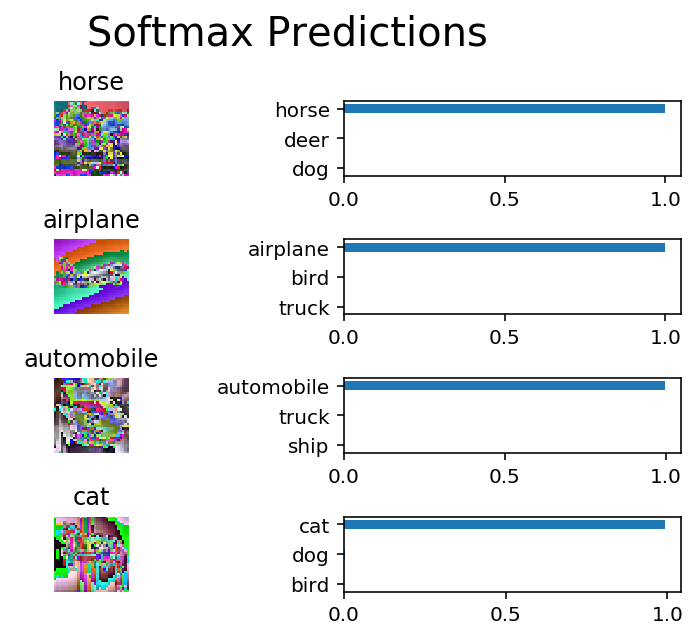

In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """
    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()
    test_features = np.transpose(test_features,(0, 3, 1, 2))
    test_features = normalize(test_features)
    
    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob_1 = loaded_graph.get_tensor_by_name('keep_prob_1:0')
        loaded_keep_prob_2 = loaded_graph.get_tensor_by_name('keep_prob_2:0')
        loaded_keep_prob_3 = loaded_graph.get_tensor_by_name('keep_prob_3:0')
        loaded_keep_prob_4 = loaded_graph.get_tensor_by_name('keep_prob_4:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        loaded_train_flag = loaded_graph.get_tensor_by_name('train_flag:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            
            test_batch_acc_total += sess.run(loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, 
                           loaded_keep_prob_1: 1.0, loaded_keep_prob_2: 1.0,
                           loaded_keep_prob_3: 1.0, loaded_keep_prob_4: 1.0,
                           loaded_train_flag:False})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
        
        random_test_predictions = sess.run(tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, 
                       loaded_keep_prob_1: 1.0, loaded_keep_prob_2: 1.0,
                        loaded_keep_prob_3: 1.0, loaded_keep_prob_4: 1.0,
                       loaded_train_flag:False})
        random_test_features = np.transpose(random_test_features,(0, 2, 3, 1))
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model()

2x64, 2x128, 3x256, 6x512(keep_prob:0.6), 5 max pooling layer, 300 epochs : 91.1%  
2x64, 2x128, 3x256, 6x512, 4 max pooling layer, 300 epochs : 90.9%

14 layers, Flipr(0.5), Flipud(0.2), 0.3(crop(2)), 0.3(Affine), 0.3(Gaussian(0,3)), 0.3(GaussianNoise(0,0.05*255),per channel 0.5), 0.3(Multiply(0.8,1.2), 400 epochs: 92%, 1200 epochs : 92.8%, 2000 epochs:93.1%, 4000 epochs:93.0%